### Load data

In [28]:
import mne

data_path = r"data\first_try\mati\mati_test_imagery_movement_1.bdf"
raw = mne.io.read_raw_bdf(data_path, preload=True)
raw.info

Extracting EDF parameters from d:\STUDIA\ZPB2\3. Data gathering\data\first_try\mati\mati_test_imagery_movement_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 673791  =      0.000 ...   329.000 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 23 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2025-10-31 12:50:57 UTC
 nchan: 24
 projs: []
 sfreq: 2048.0 Hz
 subject_info: <subject_info | his_id: >
>

### Select only significant channels

In [29]:
eeg_channels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]
raw.pick(picks=eeg_channels+["Status"]).load_data()

<RawEDF | mati_test_imagery_movement_1.bdf, 17 x 673792 (329.0 s), ~87.4 MiB, data loaded>

### Annotate data

In [ ]:
import mne
import pandas as pd
import numpy as np

print("Frequency:", raw.info["sfreq"], "Hz")
print("Channels:", len(raw.ch_names))
print("Duration:", raw.n_times / raw.info["sfreq"], "s")

events = mne.find_events(raw, stim_channel="Status", shortest_event=1, consecutive=True)
sfreq = raw.info["sfreq"]

df = pd.DataFrame(events, columns=["sample", "previous", "event_id"])
df["onset_s"] = df["sample"] / sfreq
mask = ((df["event_id"].to_numpy(np.uint32) & 0xFF00) >> 8).astype(int)
map_key = {1:"R", 2:"LH", 4:"RH", 8:"BH", 16:"BF"}
df["key"] = [map_key.get(m) for m in mask]
df = df[df["key"].notna()][["onset_s","key"]]
df["duration_s"] = df["onset_s"].diff().shift(-1)
print(df[:20])
annotations = mne.Annotations(onset=df["onset_s"], description=df["key"], duration=df["duration_s"])
raw.set_annotations(annotations)

raw.pick(picks=eeg_channels)

Częstotliwość próbkowania: 2048.0 Hz
Liczba kanałów: 17
Czas trwania: 329.0 s
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65791 (consider using initial_event=True to detect this event)
83 events found on stim channel Status
Event IDs: [ 255  511  767 1279 2303 4351]
       onset_s key  duration_s
1     5.304688   R   10.328125
3    15.632812  LH   10.265625
5    25.898438   R    5.570312
7    31.468750  RH   10.007812
9    41.476562   R    5.921875
11   47.398438  BH    9.312500
13   56.710938   R    5.671875
15   62.382812  BF   10.046875
17   72.429688   R    6.015625
19   78.445312  LH   10.156250
21   88.601562   R    5.953125
23   94.554688  RH   10.046875
25  104.601562   R    5.609375
27  110.210938  BH    9.984375
29  120.195312   R    6.015625
31  126.210938  BF   10.609375
33  136.820312   R    5.796875
35  142.617188  LH   10.484375
37  153.101562   R    5.453125
39  158.554688  RH   10.328125


<RawEDF | mati_test_imagery_movement_1.bdf, 16 x 673792 (329.0 s), ~82.3 MiB, data loaded>

### Show raw 

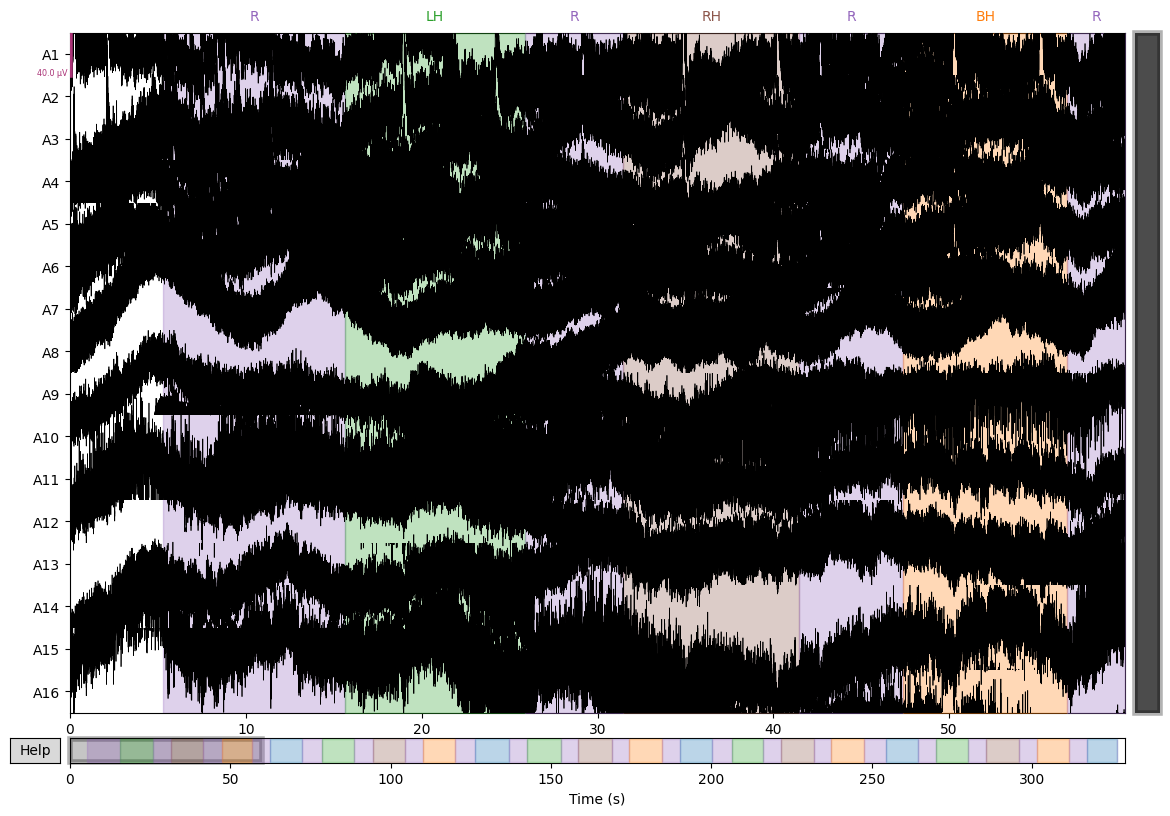

In [31]:
raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=True)
pass # to prevent double plotting

### Resample data, apply simple preprocessing and plot it

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

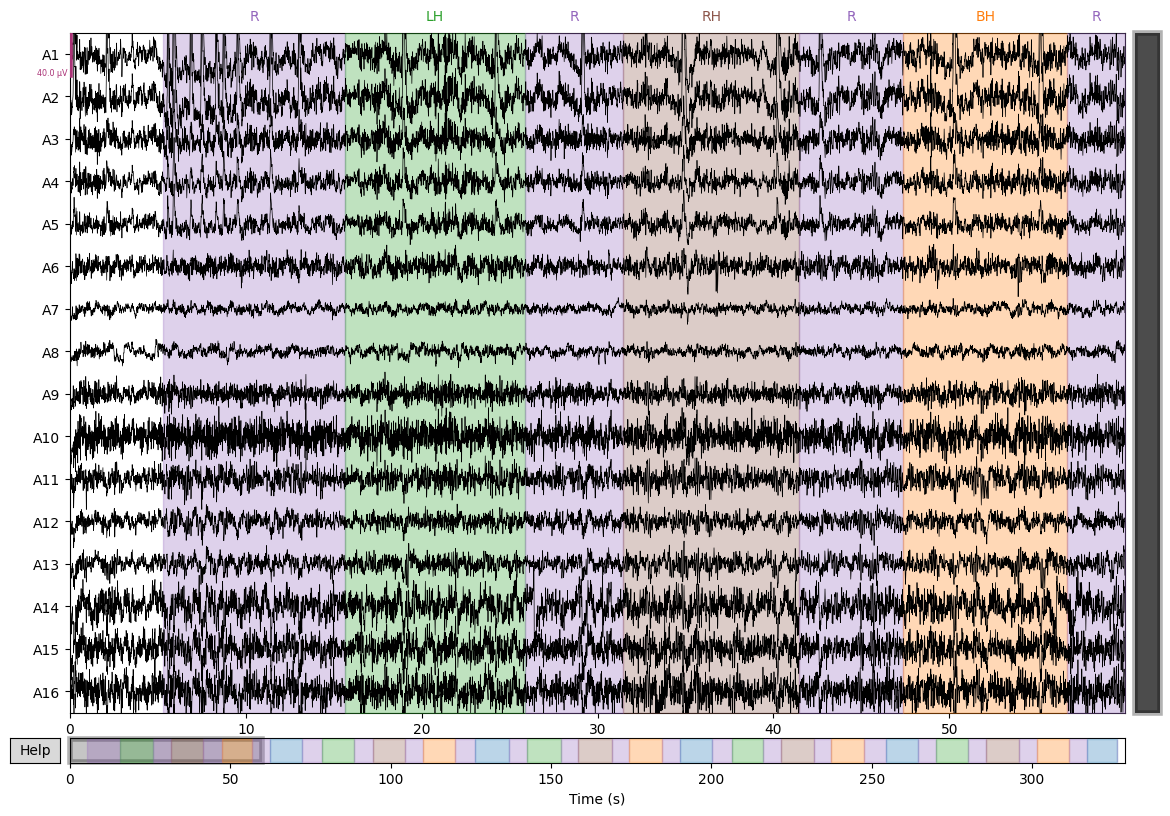

In [ ]:
filtered = raw.copy().resample(sfreq=250)
filtered.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
filtered.notch_filter(freqs=[50.0])

filtered.plot(duration=60, proj=False, n_channels=len(filtered.ch_names), remove_dc=True)
pass

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


Text(0.5, 0.98, 'Original')

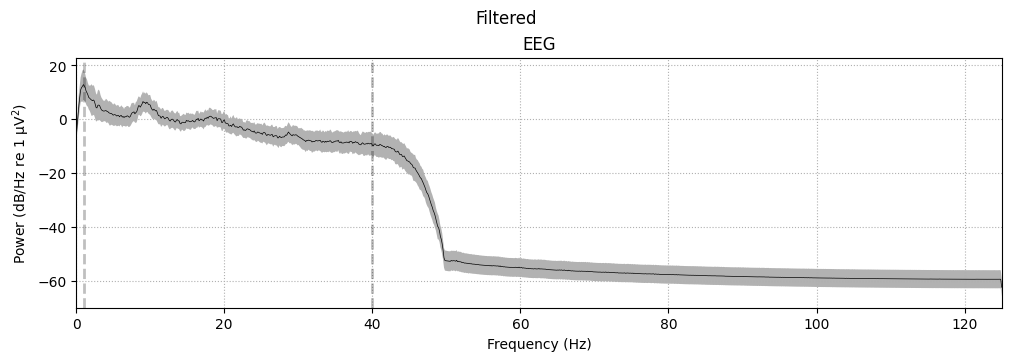

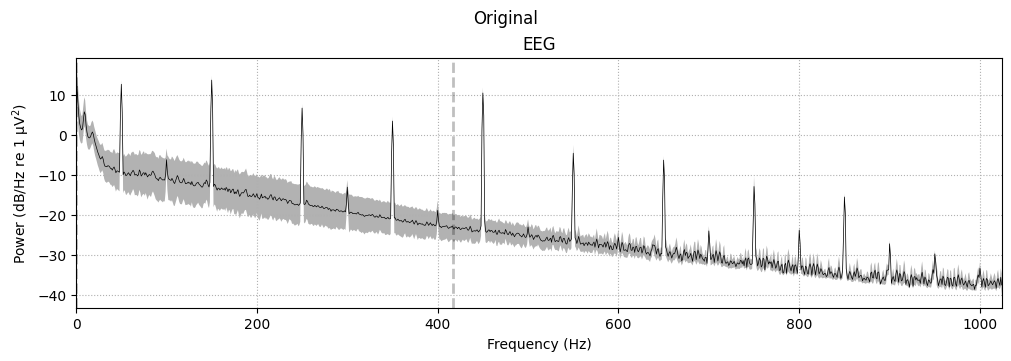

In [33]:
%matplotlib inline

fig = filtered.compute_psd().plot(average=True, picks="data", show=False)
fig.suptitle("Filtered")
fig = raw.compute_psd().plot(average=True, picks="data", show=False)
fig.suptitle("Original")

### Filtered data showcase
Original (raw) does not show up on plot because amplitude is higher than default for plot (40 microvolt)

Filtered with removed DC plot (remove_dc=True) should be the same as just filtered as 50Hz Butterworth filter was already applied  

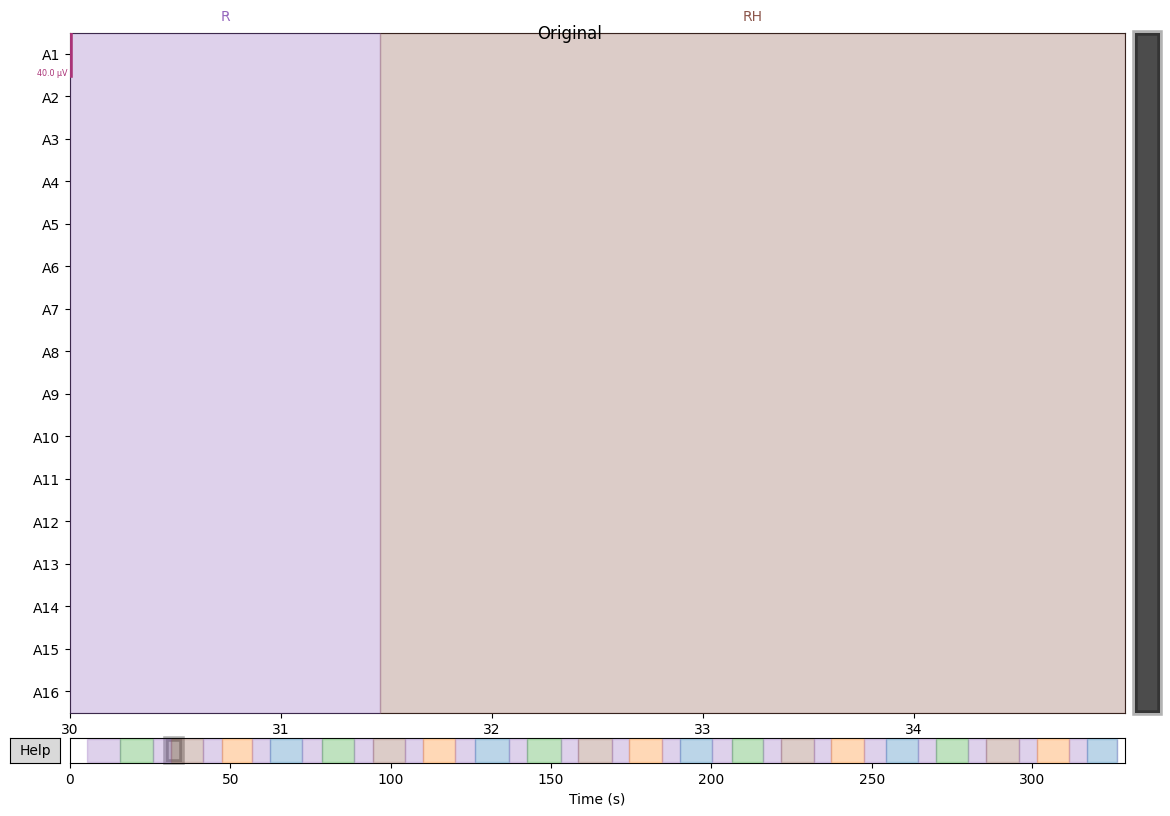

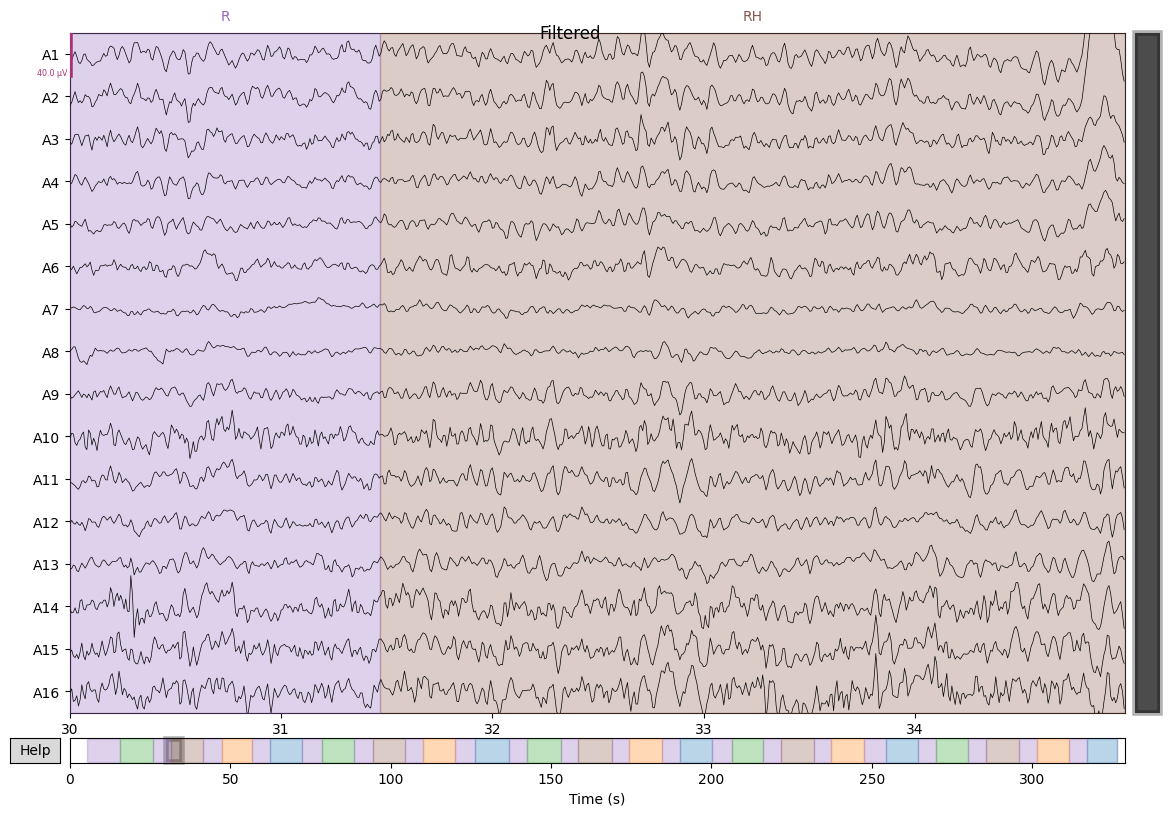

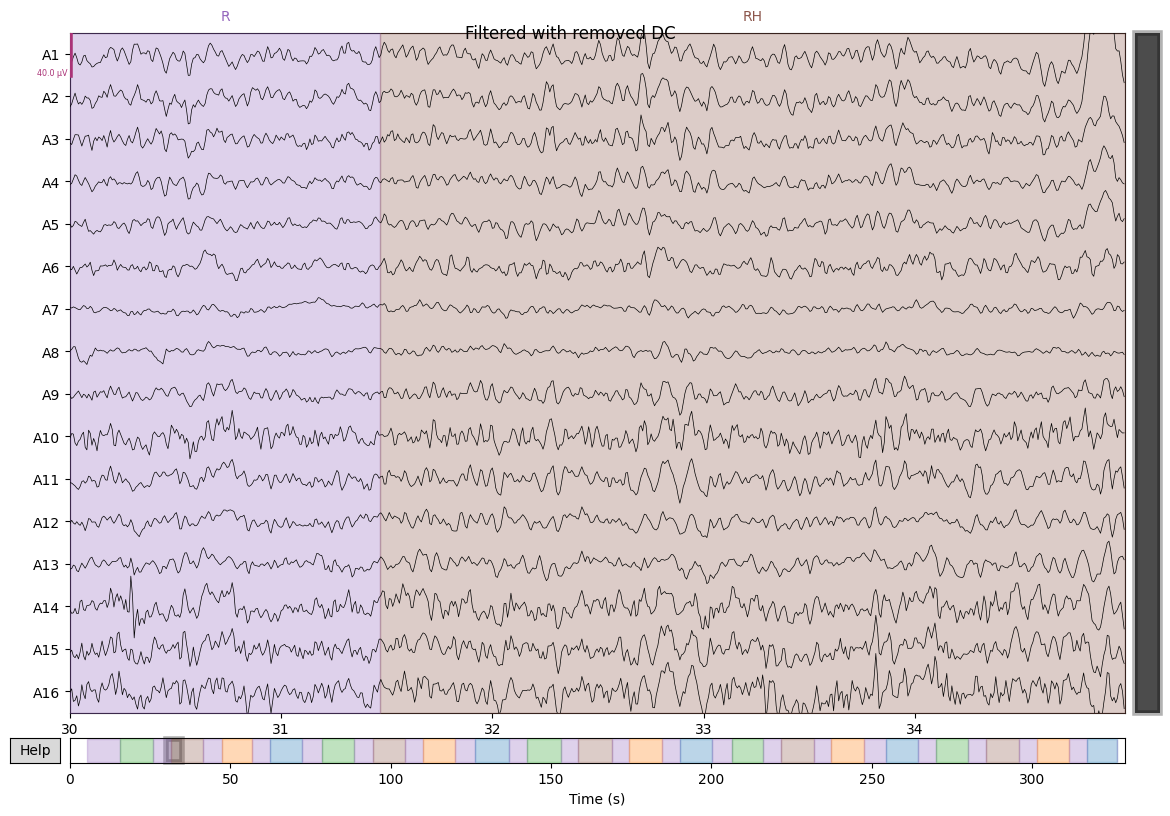

In [34]:
start = 30
duration = 5

with mne.viz.use_browser_backend("matplotlib"):
    for data, title in zip([raw, filtered], ["Original", "Filtered"]):
        fig = data.plot(start=start, duration=duration, proj=False, n_channels=len(raw.ch_names), remove_dc=False, show=False)
        fig.suptitle(title)
        if title == "Filtered":
            fig = data.plot(start=start, duration=duration, proj=False, n_channels=len(raw.ch_names), remove_dc=True, show=False)
            fig.suptitle("Filtered with removed DC")
        
